In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
data = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv',parse_dates=['Date'], index_col='Date')

In [22]:
print(data.head())
print(data.dtypes)
print(data.index)

             Open   High    Low  Close     Volume  Name
Date                                                   
2006-01-03  10.34  10.68  10.32  10.68  201853036  AAPL
2006-01-04  10.73  10.85  10.64  10.71  155225609  AAPL
2006-01-05  10.69  10.70  10.54  10.63  112396081  AAPL
2006-01-06  10.75  10.96  10.65  10.90  176139334  AAPL
2006-01-09  10.96  11.03  10.82  10.86  168861224  AAPL
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object
DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=3019, freq=None)


In [23]:
ts = data['Open']

In [24]:
ts.head()

Date
2006-01-03    10.34
2006-01-04    10.73
2006-01-05    10.69
2006-01-06    10.75
2006-01-09    10.96
Name: Open, dtype: float64

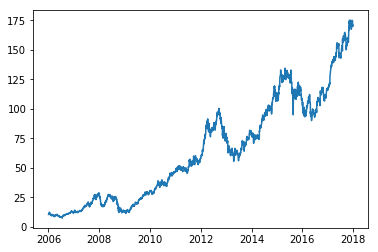

In [30]:
plt.plot(ts)

In [40]:
#Rolling statistics & Dickey-Fuller test from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
#Used to test for stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

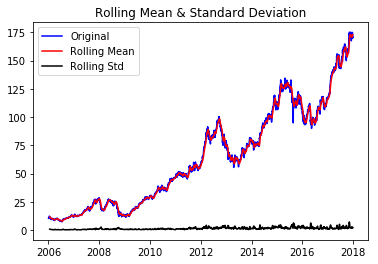

Results of Dickey-Fuller Test:
Test Statistic                    0.589688
p-value                           0.987359
#Lags Used                       22.000000
Number of Observations Used    2996.000000
Critical Value (1%)              -3.432535
Critical Value (5%)              -2.862505
Critical Value (10%)             -2.567284
dtype: float64


In [41]:
test_stationarity(ts)

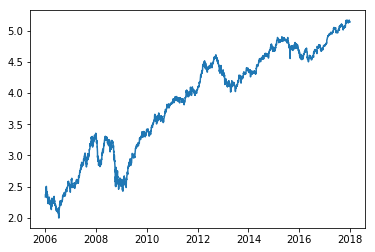

In [43]:
#Converting to log
ts_log = np.log(ts)
plt.plot(ts_log)

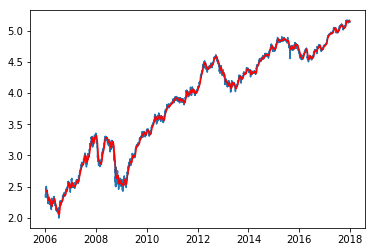

In [50]:
#This method is not useful as t-stat > 5% critical value
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [51]:
#This method is not useful as t-stat > 5% critical value
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
2006-01-03         NaN
2006-01-04         NaN
2006-01-05         NaN
2006-01-06         NaN
2006-01-09         NaN
2006-01-10         NaN
2006-01-11         NaN
2006-01-12         NaN
2006-01-13         NaN
2006-01-17         NaN
2006-01-18         NaN
2006-01-19    0.023349
Name: Open, dtype: float64

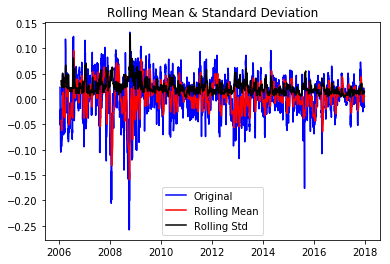

Results of Dickey-Fuller Test:
Test Statistic                -1.148907e+01
p-value                        4.785368e-21
#Lags Used                     1.300000e+01
Number of Observations Used    2.994000e+03
Critical Value (1%)           -3.432536e+00
Critical Value (5%)           -2.862506e+00
Critical Value (10%)          -2.567284e+00
dtype: float64


In [54]:
#This method is not useful as t-stat > 5% critical value
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

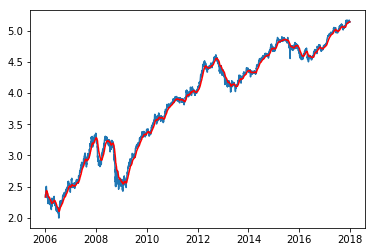

In [58]:
#This method is not useful as t-stat > 5% critical value
#But is better than simple moving average
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

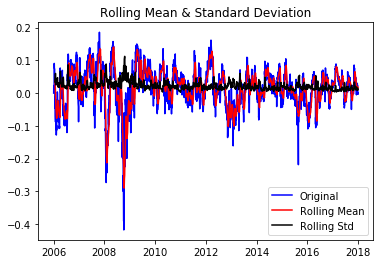

Results of Dickey-Fuller Test:
Test Statistic                -8.362928e+00
p-value                        2.791993e-13
#Lags Used                     1.000000e+00
Number of Observations Used    3.017000e+03
Critical Value (1%)           -3.432519e+00
Critical Value (5%)           -2.862498e+00
Critical Value (10%)          -2.567280e+00
dtype: float64


In [59]:
#This method is not useful as t-stat > 5% critical value
#But is better than simple moving average
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

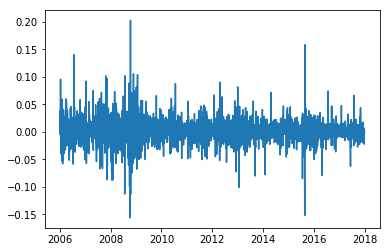

In [60]:
#Differencing to remove trend & seasonality
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

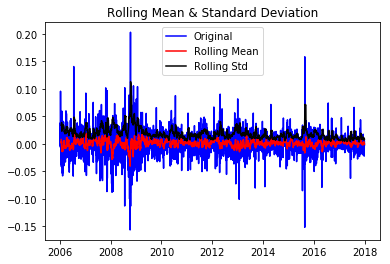

Results of Dickey-Fuller Test:
Test Statistic                  -27.017736
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    3014.000000
Critical Value (1%)              -3.432521
Critical Value (5%)              -2.862499
Critical Value (10%)             -2.567281
dtype: float64


In [61]:
#Differencing to remove trend & seasonality
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

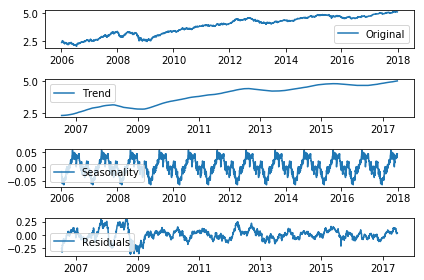

In [73]:
#Decomposing to remove seasonality and trend
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,freq=260)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

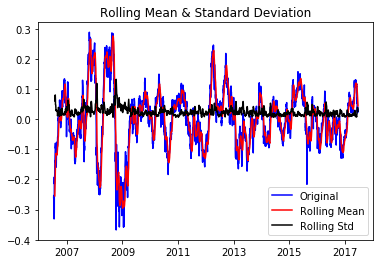

Results of Dickey-Fuller Test:
Test Statistic                -5.698206e+00
p-value                        7.785010e-07
#Lags Used                     4.000000e+00
Number of Observations Used    2.754000e+03
Critical Value (1%)           -3.432727e+00
Critical Value (5%)           -2.862590e+00
Critical Value (10%)          -2.567329e+00
dtype: float64


In [74]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [75]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [76]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

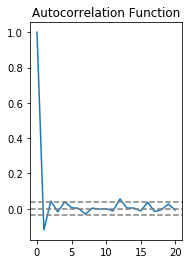

In [77]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

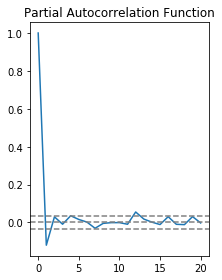

In [78]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [79]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.4387')

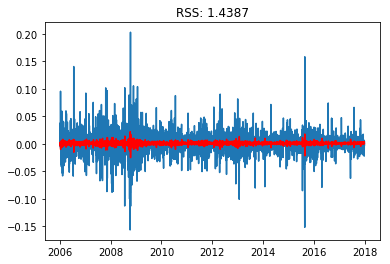

In [80]:
#AR Model
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 1.4391')

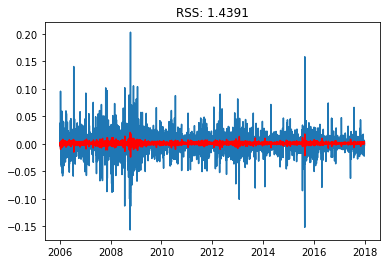

In [81]:
#MA Model
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Jackson\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `fl

Text(0.5,1,'RSS: 1.4373')

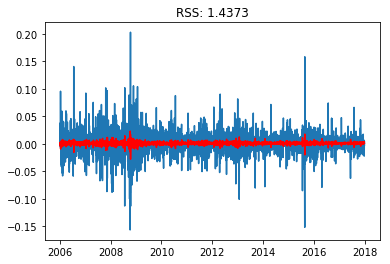

In [82]:
#Combined Model
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [84]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2006-01-04    0.000946
2006-01-05   -0.003224
2006-01-06    0.002427
2006-01-09   -0.000131
2006-01-10   -0.000616
dtype: float64


In [86]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
2006-01-04    0.000946
2006-01-05   -0.002278
2006-01-06    0.000149
2006-01-09    0.000018
2006-01-10   -0.000597
dtype: float64


In [88]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\Jackson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2006-01-03    2.336020
2006-01-04    2.336966
2006-01-05    2.333742
2006-01-06    2.336169
2006-01-09    2.336038
dtype: float64

Text(0.5,1,'RMSE: 17.3621')

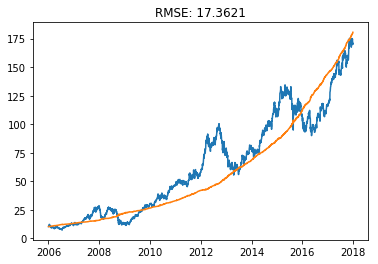

In [89]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))